# Lab 03: computing empirical probabilities, empirical CDFs, and empirical PDFs
CCNY EAS 42000/A42000, Fall 2025, 2025/10/08, Prof. Spencer Hill

**SUMMARY**: We use `xarray` to load the `netCDF` file containing the Central Park weather station daily data from disk, and then a combination of `xarray` and `scipy` to compute empirical probabilites, CDFs, and PDFs from that data.

# Preliminaries

## Notebook magic commands

(There are two of these.  The first you should include; the second only matters if you are on a Mac computer with a Retina display.)

In [1]:
# Turn on rendering of matplotlib figures directly in the notebook.
%matplotlib inline  
# OPTIONAL.  Make figures higher resolution on my Macbook.
%config InlineBackend.figure_format = "retina"  

## Imports

In [2]:
from matplotlib import pyplot as plt  # for plotting
import scipy  # for computing empirical CDFs
import xarray as xr  # for loading data and subsequent analyses

## Check that your version of scipy has the `scipy.stats.ecdf` function, which was introduced in 2023

In [3]:
scipy.stats.ecdf

<function scipy.stats._survival.ecdf(sample: 'npt.ArrayLike | CensoredData') -> scipy.stats._survival.ECDFResult>

If the cell just above gives you a `NameError`, that means that you don't have a recent enough version of scipy.  You can resolve this by updating your installed `scipy` to a newer version using `pip` or `conda`.  Consult HW03 for further instructions.

## Load Central Park weather station data from disk

In [4]:
# Modify `filepath_in` as needed to point to where the dataset lives on your machine.
# It can be an *absolute path*, or a *relative path*, meaning relative to the 
# directory that this notebook lives in.
# One dot, `.` means "the current directory."  Two dots, `..` means "go up one directory."
filepath_in = "../data/central-park-station-data_1869-01-01_2023-09-30.nc"  
ds_cp = xr.open_dataset(filepath_in)
ds_cp

<xarray.Dataset> Size: 5MB
Dimensions:        (time: 56520)
Coordinates:
  * time           (time) datetime64[ns] 452kB 1869-01-01 ... 2023-09-30
Data variables:
    temp_max       (time) int64 452kB ...
    temp_min       (time) int64 452kB ...
    temp_avg       (time) float64 452kB ...
    temp_anom      (time) float64 452kB ...
    heat_deg_days  (time) int64 452kB ...
    cool_deg_days  (time) int64 452kB ...
    precip         (time) float64 452kB ...
    snow_fall      (time) float64 452kB ...
    snow_depth     (time) int64 452kB ...

# Empirical probabilities

Recall: the empirical probability of an event $E$ is simply the number of times $E$ occurs, divided by the total number of times it *could* have occurred.

The built-in `len` function is helpful for this.


## Technical aside: jupyter question mark `?` vs. built-in `help` function

Recall that in a Jupyter session, entering the name of an object followed by a question mark will display information about that object.

If you're reading this as the rendered HTML of this notebook, cells that call Jupyter's `?` feature will not actually show anything, for technical reasons.  For example:

In [5]:
len?

Signature: len(obj, /)
Docstring: Return the number of items in a container.
Type:      builtin_function_or_method

But if you run this yourself in a jupyter session, you *will* get output, specifically:

```
Signature: len(obj, /)
Docstring: Return the number of items in a container.
Type:      builtin_function_or_method
```

As such, I'll use the builtin `help` function, which gives you similar output and *does* render in both a running notebook *and* the rendered HTML.
:::

In [6]:
help(len)

Help on built-in function len in module builtins:

len(obj, /)
    Return the number of items in a container.



The downsides of `help` compared to `?` are: 
- `help` is not as detailed,
- not formatted as nicely (including colors)
- requires typing more characters.

## Example: days with average temperature > 70F

The numerator is simply the number of days meeting this condition.

How do we do this in python/xarray?  The first tsep is really simple.  Simply use the "greater than" operator, `>`, directly on the xr.DataArray object:

In [7]:
ds_cp["temp_avg"] > 70  # this MASKS out values not meeting this condition

<xarray.DataArray 'temp_avg' (time: 56520)> Size: 57kB
array([False, False, False, ..., False, False, False], shape=(56520,))
Coordinates:
  * time     (time) datetime64[ns] 452kB 1869-01-01 1869-01-02 ... 2023-09-30

The resulting xr.DataArray is identical in *shape* to the original `ds_cp["temp_avg"]`, but its values are all `bool`: they are `True` where the condition is satisfied and `False` where it is not satisfied.

As a sanity check, let's plot this new array.  You'll see that all of its values are 70F or greater, as intended:

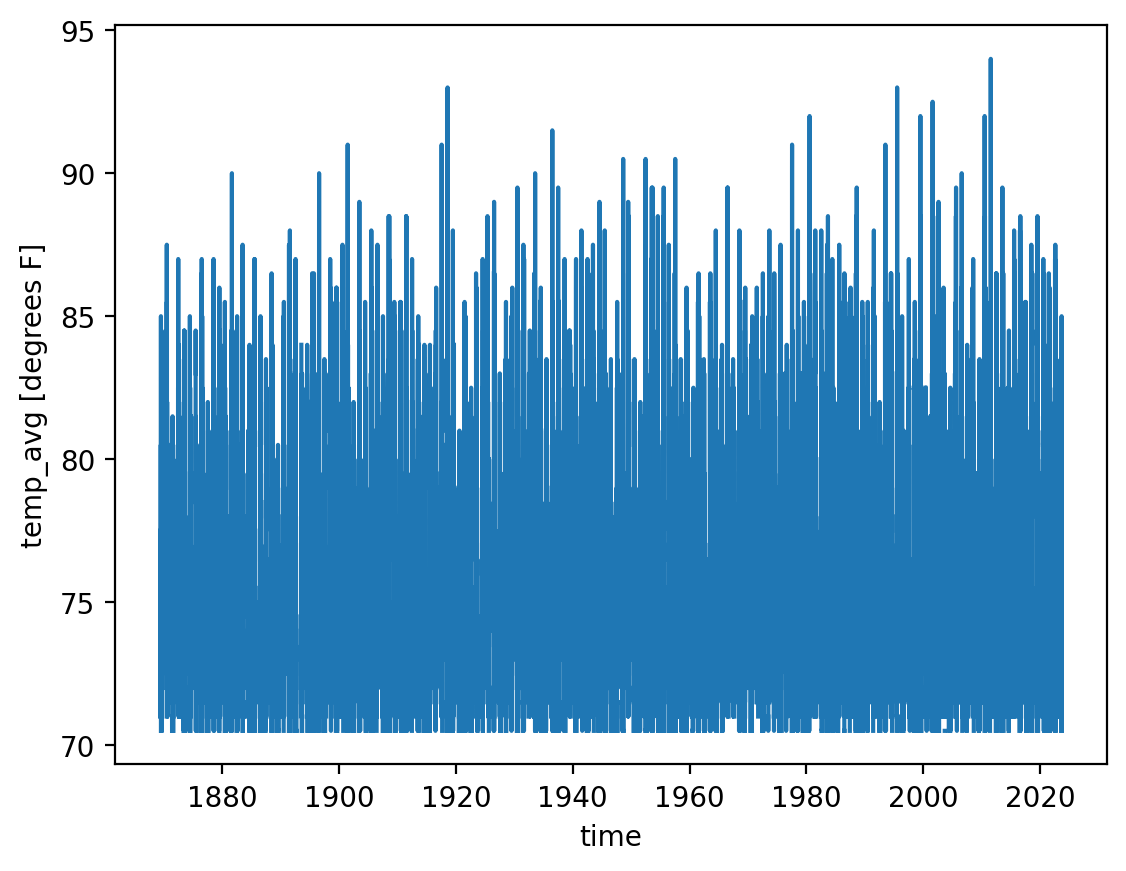

In [8]:
ds_cp["temp_avg"].where(ds_cp["temp_avg"] > 70).plot()

Now let's assign this result to its own variable for use later on:

In [9]:
is_temp_avg_above_70 = ds_cp["temp_avg"] > 70  

Next, we use `is_temp_avg_above_70` as the input to the [`where`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.where.html) method of `xr.DataArray` to create a *mask* that restricts to only the data points meeting that condition.

We also use set `drop=True`, so that the points not meeting this condition are dropped entirely.  (The default, `drop=False`, leaves them in place but replaces their values with `np.nan`, which means "Not a Number.")

In [10]:
temp_avg_above_70 = ds_cp["temp_avg"].where(is_temp_avg_above_70, drop=True)
temp_avg_above_70

<xarray.DataArray 'temp_avg' (time: 13401)> Size: 107kB
array([71.5, 71.5, 74.5, ..., 75.5, 75. , 74.5], shape=(13401,))
Coordinates:
  * time     (time) datetime64[ns] 107kB 1869-05-12 1869-05-25 ... 2023-09-13
Attributes:
    units:    degrees F

From visually inspecting this output, you can see that the there are 13,401 days satisfying this condition.

You could, if you wanted, then *hardcode* that value into a new variable.  E.g. `num_days_above70 = 13401`.

However, we want to avoid hardcoding numerical values in like this whenever possible.  Instead, we want to write code that outputs that 13401 value directly.

As noted above, a really easy way of doing that is with `len`:

In [11]:
len(temp_avg_above_70)

13401

So let's store that in its own variable:

In [12]:
num_days_temp_avg_above_70 = len(temp_avg_above_70)
num_days_temp_avg_above_70

13401

:::{admonition} Alternative approach: use the `count` method
:class: note
As is often the case in programming, there are multiple ways of accomplishing the same thing here.  One equally elegant solution would be to use the builtin `count` method of `xr.DataArray`: `ds_cp["temp_avg"].where(is_temp_avg_above_70).count()`.

Notice there you don't have to set `drop=True`: `count` automatically ignores masked values, meaning values that are `nan`.

(Hat tip to Storm H. for showing me `count`!)
:::

Now we have the numerator.  The denominator is much easier.  It's simply the total number of days in the dataset:

In [13]:
total_days = len(ds_cp["temp_avg"])
total_days

56520

Finally, we can put it all together:

In [14]:
# Q1: P(temp_avg > 70F)
denom = total_days
numer = num_days_temp_avg_above_70
emp_prob = numer / denom
print(f"Numerator: {numer}, denominator: {denom}, empirical probability: {emp_prob}")

Numerator: 13401, denominator: 56520, empirical probability: 0.23710191082802548


## Selecting individual months of the year

Often, including for some of the empirical probability problems on this assignment, you need to select a subset in time of your dataset.  

For example, one of the problems asks you about days in the month of July.

In this case and often, the `time` coordinate is stored as a special type of object, which you can think of as a kind of calendar. 

These calendar objects have lots of handy builtin tools for slicing and dicing time in different ways: by year, by day of the week, by month, etc. etc.

We access these via a special `dt` *accessor*, which you get to simply by appending `.dt` to the time array itself: `ds_cp["time"]` is the time array, so it's `ds_cp["time"].dt`.

Let's use the builtin `dir` function to see what all is available to us from this `dt` accessor:

In [15]:
dir(ds_cp["time"].dt)

['__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__orig_class__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_date_field',
 '_obj',
 '_tslib_round_accessor',
 'calendar',
 'ceil',
 'date',
 'day',
 'dayofweek',
 'dayofyear',
 'days_in_month',
 'days_in_year',
 'daysinmonth',
 'decimal_year',
 'floor',
 'hour',
 'is_leap_year',
 'is_month_end',
 'is_month_start',
 'is_quarter_end',
 'is_quarter_start',
 'is_year_end',
 'is_year_start',
 'isocalendar',
 'microsecond',
 'minute',
 'month',
 'nanosecond',
 'quarter',
 'round',
 'season',
 'second',
 'strftime

We can access any of these by simply adding them on to the `dt`.  For example, if we want the month:

In [16]:
ds_cp["time"].dt.month

<xarray.DataArray 'month' (time: 56520)> Size: 452kB
array([1, 1, 1, ..., 9, 9, 9], shape=(56520,))
Coordinates:
  * time     (time) datetime64[ns] 452kB 1869-01-01 1869-01-02 ... 2023-09-30

This is an `xr.DataArray` that is identical to our original time array, but instead of its values being the actual date, the values are the number of the calendar month of that particular date.  So the first one, which is January 1, 1869, is `1`.  Any dates that are in February are `2`, and so on through `12` for dates in December.

So putting that all together:

In [17]:
# select just July days
ds_cp.where(ds_cp["time"].dt.month == 7, drop=True)  

<xarray.Dataset> Size: 384kB
Dimensions:        (time: 4805)
Coordinates:
  * time           (time) datetime64[ns] 38kB 1869-07-01 ... 2023-07-31
Data variables:
    temp_max       (time) float64 38kB 70.0 76.0 84.0 83.0 ... 89.0 80.0 85.0
    temp_min       (time) float64 38kB 62.0 64.0 70.0 72.0 ... 70.0 66.0 66.0
    temp_avg       (time) float64 38kB 66.0 70.0 77.0 77.5 ... 79.5 73.0 75.5
    temp_anom      (time) float64 38kB -10.3 -6.4 0.4 0.7 ... 5.8 1.9 -4.6 -2.0
    heat_deg_days  (time) float64 38kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cool_deg_days  (time) float64 38kB 1.0 5.0 12.0 13.0 ... 19.0 15.0 8.0 11.0
    precip         (time) float64 38kB 0.0 0.0 0.42 0.0 0.0 ... 0.0 0.06 0.0 0.0
    snow_fall      (time) float64 38kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    snow_depth     (time) float64 38kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

Hint: for another one of the problems, try `dt.dayofweek`.

# Empirical CDFs

Let's start by getting some info about the `scipy.stats.ecdf` function we'll be using:

In [18]:
# c.f. note above: you can alternatively use `scipy.stats.ecdf?`
help(scipy.stats.ecdf)

Help on function ecdf in module scipy.stats._survival:

ecdf(sample: 'npt.ArrayLike | CensoredData') -> scipy.stats._survival.ECDFResult
    Empirical cumulative distribution function of a sample.

    The empirical cumulative distribution function (ECDF) is a step function
    estimate of the CDF of the distribution underlying a sample. This function
    returns objects representing both the empirical distribution function and
    its complement, the empirical survival function.

    Parameters
    ----------
    sample : 1D array_like or `scipy.stats.CensoredData`
        Besides array_like, instances of `scipy.stats.CensoredData` containing
        uncensored and right-censored observations are supported. Currently,
        other instances of `scipy.stats.CensoredData` will result in a
        ``NotImplementedError``.

    Returns
    -------
    res : `~scipy.stats._result_classes.ECDFResult`
        An object with the following attributes.

        cdf : `~scipy.stats._result_clas

OK, so let's call it on our daily maximum temperature variable:

In [19]:
ecdf_temp_max = scipy.stats.ecdf(ds_cp["temp_max"])
ecdf_temp_max

ECDFResult(cdf=EmpiricalDistributionFunction(quantiles=array([  0.,   2.,   4.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
        25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
        36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,
        47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,
        58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,
        69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
        80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101.,
       102., 103., 104., 106.]), probabilities=array([0.00125619, 0.00127389, 0.00130927, 0.00134466, 0.00143312,
       0.00155697, 0.00166313, 0.00189314, 0.00205237, 0.00228238,
       0.00258316, 0.00290163, 0.00334395, 0.00389243, 0.00442321,
       0.00530786, 0.00631635, 0.0080502

Rather than a simple `numpy` array or `xr.DataArray`, this creates a `ECDFResult` object.

From the output, it looks like this has two attributes, `cdf` and `sf`.  Most likely of course `cdf` is the one we're after.

But since we're not familiar, let's use `help` (or the question mark) again to see what we can do with this:

In [20]:
help(ecdf_temp_max)

Help on ECDFResult in module scipy.stats._survival object:

class ECDFResult(builtins.object)
 |  ECDFResult(q, cdf, sf, n, d)
 |
 |  Result object returned by `scipy.stats.ecdf`
 |
 |  Attributes
 |  ----------
 |  cdf : `~scipy.stats._result_classes.EmpiricalDistributionFunction`
 |      An object representing the empirical cumulative distribution function.
 |  sf : `~scipy.stats._result_classes.EmpiricalDistributionFunction`
 |      An object representing the complement of the empirical cumulative
 |      distribution function.
 |
 |  Methods defined here:
 |
 |  __eq__(self, other)
 |      Return self==value.
 |
 |  __init__(self, q, cdf, sf, n, d)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  __replace__ = _replace(self, /, **changes) from dataclasses
 |
 |  __repr__(self)
 |      Return repr(self).
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for 

OK, so indeed under the "Attributes" heading, it clearly says that the `cdf` is what represents the CDF we're interested in.  So let's take a look:

In [21]:
ecdf_temp_max.cdf

EmpiricalDistributionFunction(quantiles=array([  0.,   2.,   4.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
        25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
        36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,
        47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,
        58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,
        69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
        80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101.,
       102., 103., 104., 106.]), probabilities=array([0.00125619, 0.00127389, 0.00130927, 0.00134466, 0.00143312,
       0.00155697, 0.00166313, 0.00189314, 0.00205237, 0.00228238,
       0.00258316, 0.00290163, 0.00334395, 0.00389243, 0.00442321,
       0.00530786, 0.00631635, 0.00805025, 0.00980184, 

So this, in turn, has as attributes two arrays, `quantiles` and `probabilities`.  

We can use `help` or the question mark yet again to get more information about those:

In [22]:
help(ecdf_temp_max.cdf)

Help on EmpiricalDistributionFunction in module scipy.stats._survival object:

class EmpiricalDistributionFunction(builtins.object)
 |  EmpiricalDistributionFunction(q, p, n, d, kind)
 |
 |  An empirical distribution function produced by `scipy.stats.ecdf`
 |
 |  Attributes
 |  ----------
 |  quantiles : ndarray
 |      The unique values of the sample from which the
 |      `EmpiricalDistributionFunction` was estimated.
 |  probabilities : ndarray
 |      The point estimates of the cumulative distribution function (CDF) or
 |      its complement, the survival function (SF), corresponding with
 |      `quantiles`.
 |
 |  Methods defined here:
 |
 |  __eq__(self, other)
 |      Return self==value.
 |
 |  __init__(self, q, p, n, d, kind)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  __replace__ = _replace(self, /, **changes) from dataclasses
 |
 |  __repr__(self)
 |      Return repr(self).
 |
 |  confidence_interval(self, confidence_level=0.95, *, method='l

So we see that:

- `quantiles` is a `numpy` array (that's what `ndarray` means) storing the values of the dataset, in this case daily average temperature, at which the empirical CDF has been calculated
- `probabilities` is a `numpy` array storing the values value of the CDF at each of those quantiles.  (The "survival function" or (SF) is simply one minus the CDF, which we aren't interested in here.)

Alright, let's finally plot that:

Text(0, 0.5, 'empirical CDF')

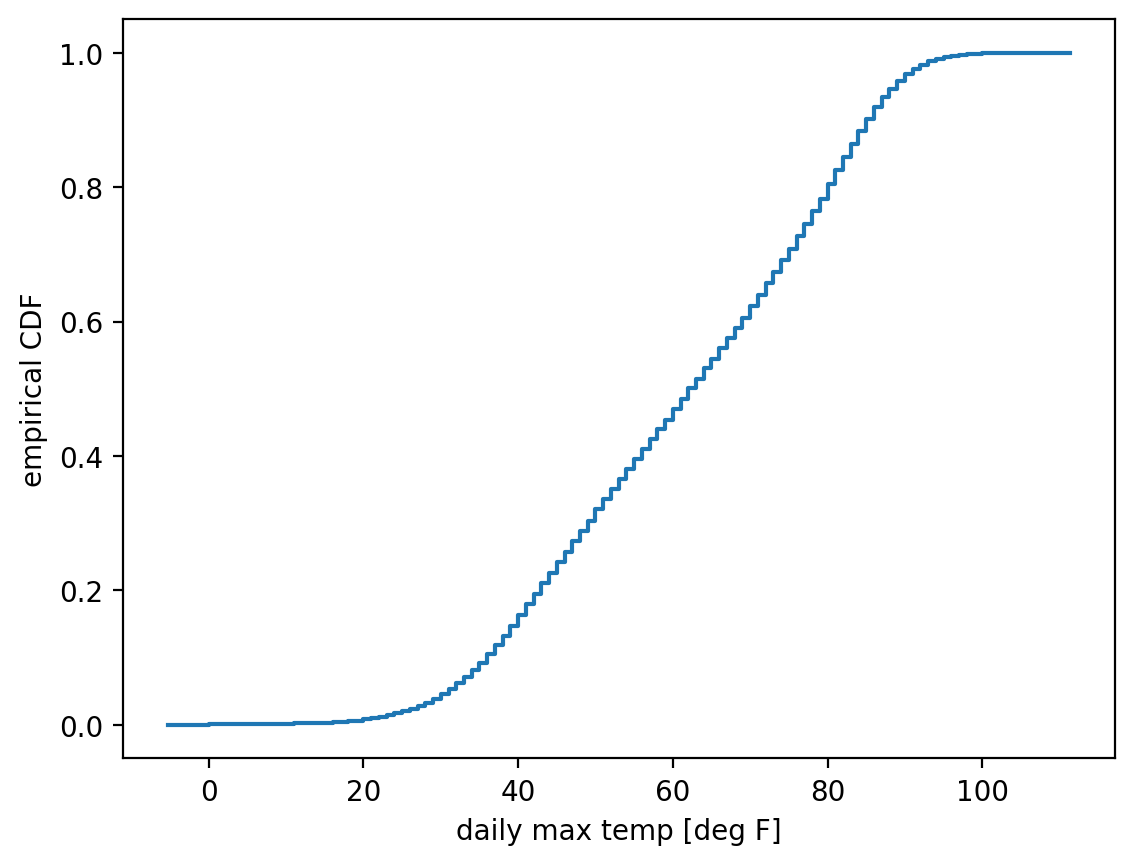

In [23]:
fig, ax = plt.subplots()  # create the overall figure and the set of axes we'll plot on.
ecdf_temp_max.cdf.plot(ax=ax)  # plot the CDF onto the `ax` object we just created.
ax.set_xlabel("daily max temp [deg F]")  # label the x axis
ax.set_ylabel("empirical CDF")  # label the y axis

:::{admonition} Alternative: use `ax.plot`
:class: note
Here, again, there are multiple ways of accomplishing the same thing.  Above, we used the builtin `plot` method of the `ecdf_temp_max.cdf` object.  We could instead have used matplotlib functions: `ax.plot(ecdf_temp_max.cdf.quantiles, ecdf_temp_max.cdf.probabilities)` to get essentially the same thing.
:::

# Empirical PDFs

Recall that an empirical probability *density* function is really just a **histogram**, crucially with the count in each bin normalized, i.e. divided, by the width of that bin.

We can get this most directly using matplotlib's `hist` function and setting `density=True`:

Text(0, 0.5, 'probability density [(deg F)$^{-1}$]')

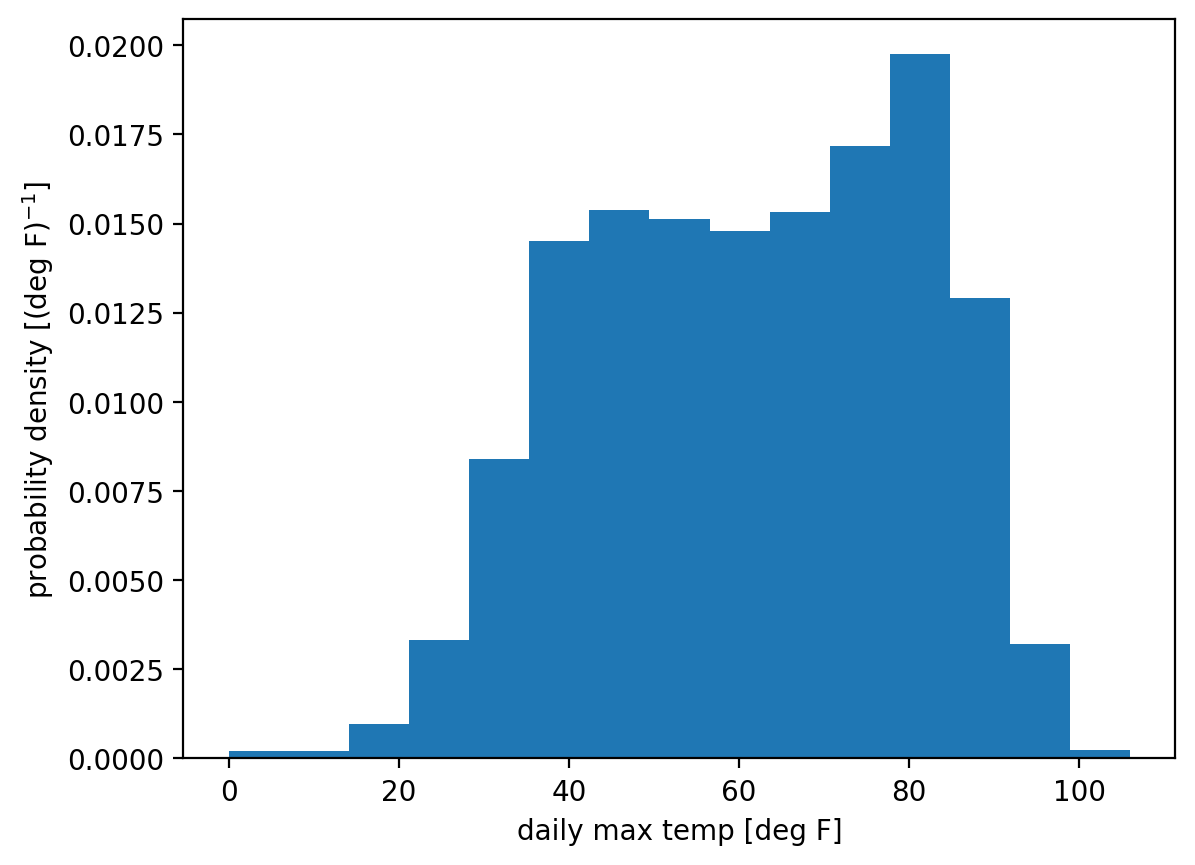

In [24]:
plt.hist(ds_cp["temp_max"], bins=15, density=True)
plt.xlabel("daily max temp [deg F]")
plt.ylabel(r"probability density [(deg F)$^{-1}$]")